In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import clean
import PIL

In [2]:
clean.run_clean()

Starting WB-I-0001...
Starting WB-I-0003...
Starting WB-I-0004...
Starting WB-I-0006...
Starting WB-I-0007...
Starting WB-I-0008...


In [3]:
data = clean.TRANSFORMED_DATA
datasets = clean.DATASETS
images = clean.IMAGE_SETS

# Dominant Color Analysis

## Dominant Image Color as a Useful, Low-Dimension Predictor
A transformation of an RGB pixel data to that image's two-most-dominant pixel colors is employed in an effort to reduce complexity of a prediction model and to reduce computational intensity during training. Examine image overlays for each image set as an approximation of each set's average image and dominant color:

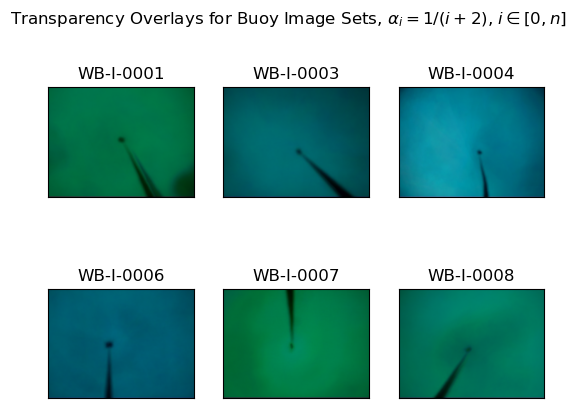

In [4]:
def superimpose_images(image_list: list[PIL.Image]) -> PIL.Image:
    superimposed = image_list.pop(0)
    
    for n, im in enumerate(image_list):
        # choosing alpha as subsequent elements of the harmonic sequence 
        # ensures each image contributes equally to the final overlay.
        alpha = 1/(n + 2)
        superimposed = PIL.Image.blend(superimposed, im, alpha)

    return superimposed

def superimposed_images() -> dict:
    # filter_sets=True removes images that are potentially not useful.
    superimposed_dict = {}
    for id, image_set in images.items():
        image_list = list(image_set["Image_array"])
        superimposed = superimpose_images(image_list)
        
        superimposed_dict[id] = superimposed
    return superimposed_dict


superimposed = superimposed_images()

fig, axes = plt.subplots(2,3)

fig.suptitle(r'Transparency Overlays for Buoy Image Sets, $\alpha_i = 1/(i+2)$, $i\in[0,n]$')
for ax, id in zip(axes.flatten(), superimposed.keys()):
    ax.imshow(superimposed[id])
    ax.title.set_text(id)
    ax.set_xticks([])
    ax.set_yticks([])
plt.savefig("./plots/transparency_overalys.png")

Aside from the angle of the buoys' instrument tethers and some vignetting, one of the primary differentiating factors between sets is the overall color of the images. Per the original studies and image collections, green color in the water is representative of higher concentration of clorophyll. The differences between image-set overlays can be partially explained by the differing date ranges of each set i.e. images collected mostly during summer (peak algal bloom) will superimpose greener than images collected from Spring to Fall. Regardless, the color differences are apparent and are inspiration for further exploration. Vignetting, while potentially containing useful information would require a more robust learning method (e.g. Convolutional Neural Network) to harness in a prediction model. Again, in the original interest of reducing complexity, the potential of dominant colors was explored.

## Quantization Method and Implementations
the `colorthief` library is based on a library originally implemented in JavaScript and uses modified median cut quantization (MMCQ) to extract RGB color palletes from RGB pixel arrays. This measurement differs from the average color of an image in that it is achieved by recursively sectioning off the 3D color space of an image (where each axis represents a color channel). The algorithm offers flexibility in terms of palette size and accounts for common errors and innacuracies not addressed by the original median cut algorithm.
* Python implementation of color thief (used in this analysis): https://github.com/fengsp/color-thief-py
* Original JavaScript implementation: https://github.com/lokesh/color-thief
* Color quantization using modified median cut algorithm (MMCQ): http://leptonica.org/papers/mediancut.pdf
* C-implementation of MMCQ with commented documentation: https://github.com/DanBloomberg/leptonica/blob/master/src/colorquant2.c

In [5]:
data = data.loc[:, data.columns != "month"]
X = data.iloc[:,-7:-1]
y = data.iloc[:,1]

## Chlorophyll concentration distribution plot

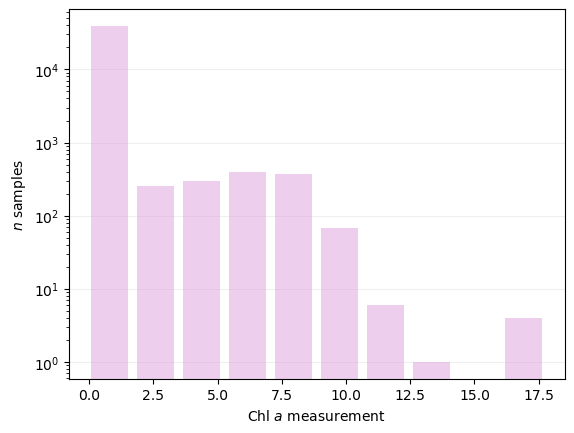

In [6]:
chl_a = pd.concat(
    [df["chl_fluorometer"].copy(deep=True) for df in datasets.values()],
    axis=0
).reset_index(drop=True)

fig, ax = plt.subplots()
ax.hist(chl_a, log=True, color="plum", alpha=0.5, rwidth=0.8)
plt.ylabel(r"$n$ samples")
plt.xlabel(r"Chl $\it{a}$ measurement")
ax.grid(axis="y", alpha=0.2)
ax.set_axisbelow(True)
plt.savefig("./plots/chl_a_dist.png")

## RGB Channel Distribution plot

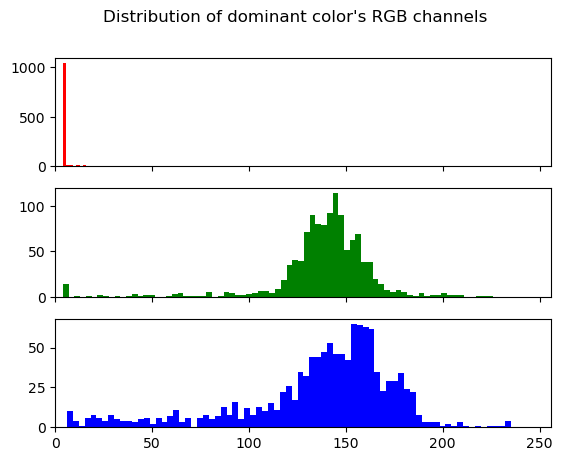

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(3)
fig.suptitle("Distribution of dominant color's RGB channels")
ax1.hist(X["r1"], color="r", bins=75)
ax2.hist(X["g1"], color="g", bins=75)
ax3.hist(X["b1"], color="b", bins=75);
for ax in (ax1, ax2, ax3):
    ax.set_xlim([0,256])
    ax.label_outer()
plt.savefig("./plots/RGB_channel_dist.png")

From the color value distributions, we can see that the red channel values are at near minimum for over 90% of the images while green and blue values appear to be mostly normal and centered between value 130-160.

## Chlorophyll vs. Domininant color channels plots

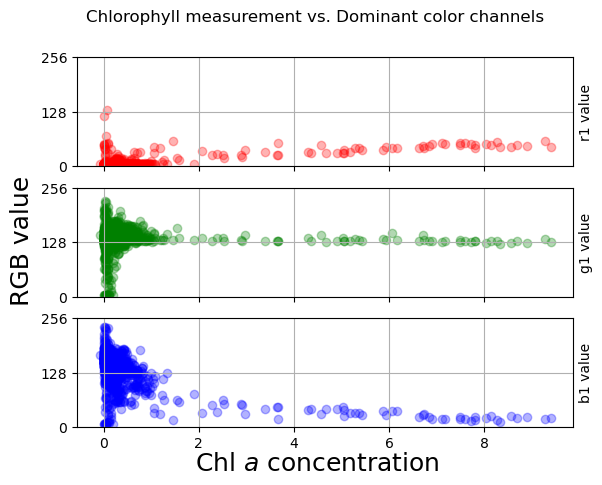

In [9]:
fig, axes = plt.subplots(3)
fig.suptitle("Chlorophyll measurement vs. Dominant color channels ")
fig.supxlabel(r'Chl $a$ concentration', size=18)
fig.supylabel("RGB value", size=18)
for ax, c in zip(axes, ("r1", "g1", "b1")):
    ax.yaxis.set_label_position("right")
    ax.scatter(y, X[c], c=c[0], alpha=0.3)
    ax.set(ylabel=f"{c} value")
    ax.set_ylim([0,256])
    ax.set_yticks([0,256//2, 256])
    ax.grid()
    ax.label_outer()
plt.savefig("./plots/chl_vs_dom_col.png")

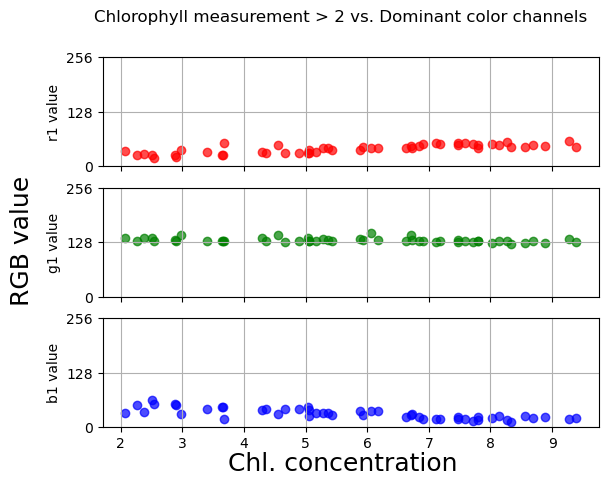

In [10]:
chl_threshold = data[(data.chl > 2)]
X_thresh = chl_threshold.iloc[:,-7:-1]
y_thresh = chl_threshold.iloc[:,1]

fig, axes = plt.subplots(3)
fig.suptitle("Chlorophyll measurement > 2 vs. Dominant color channels ")
fig.supxlabel('Chl. concentration', size=18)
fig.supylabel("RGB value", x=-.02, size=18)
for ax, c in zip(axes, ("r1", "g1", "b1")):
    ax.scatter(y_thresh, X_thresh[c], c=c[0], alpha=0.7)
    ax.set(ylabel=f"{c} value")
    ax.set_ylim([0,256])
    ax.set_yticks([0,256//2, 256])
    ax.grid()
    ax.label_outer()
plt.savefig("./plots/chl_vs_dom_col_gte2.png")

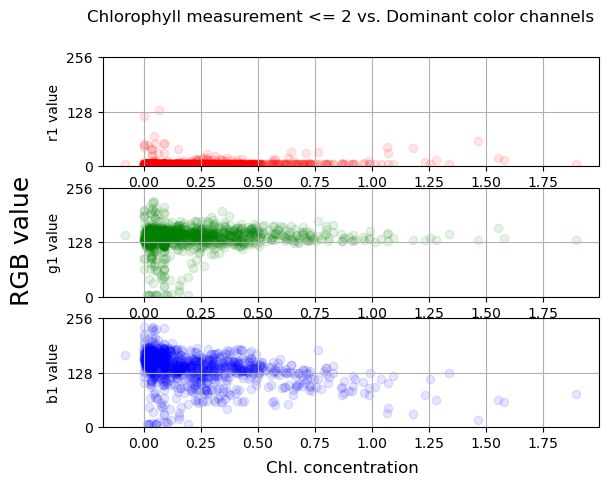

In [11]:
chl_subthreshold = data[(data.chl <= 2)]
X_subthresh = chl_subthreshold.iloc[:,-7:-1]
y_subthresh = chl_subthreshold.iloc[:,1]

fig, axes = plt.subplots(3)
fig.suptitle("Chlorophyll measurement <= 2 vs. Dominant color channels ")
fig.supxlabel('Chl. concentration')
fig.supylabel("RGB value", x=-.02, size=18)
for ax, c in zip(axes, ("r1", "g1", "b1")):
    ax.scatter(y_subthresh, X_subthresh[c], c=c[0], alpha=0.1)
    ax.set(ylabel=f"{c} value")
    ax.set_ylim([0,256])
    ax.set_yticks([0,256//2, 256])
    ax.grid()
plt.savefig("./plots/chl_vs_dom_col_gte2.png")

## Chlorophyll concentration by month of the year

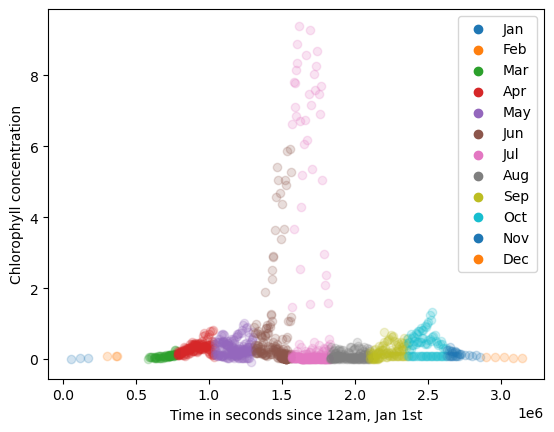

In [12]:
by_month = data.copy(deep=True)
by_month["month"] = by_month.apply(lambda x: x["Timestamp"].month, axis=1)
by_month = by_month.groupby("month")
for label, month in by_month:
    plt.scatter(month.month_day_time_int, month.chl, alpha=0.2, label=label)
leg = plt.legend(labels = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.xlabel("Time in seconds since 12am, Jan 1st")
plt.ylabel("Chlorophyll concentration");
plt.savefig("./plots/chl_vs_month.png")